In [1]:
import glob
from pathlib import Path
import pydicom
import matplotlib.pyplot as plt
import numpy as np
import cv2
from tqdm import tqdm
import os
import scipy.ndimage
import pandas as pd
import imageio

## Preprocessing funcions

In [2]:
def cropBorders(img, l=0.01, r=0.01, u=0.04, d=0.04):

    """
    This function crops a specified percentage of border from
    each side of the given image. Default is 1% from the top,
    left and right sides and 4% from the bottom side.

    Parameters
    ----------
    img : {numpy.ndarray}
        The image to crop.

    Returns
    -------
    cropped_img: {numpy.ndarray}
        The cropped image.
    """

    try:
        nrows, ncols = img.shape

        # Get the start and end rows and columns
        l_crop = int(ncols * l)
        r_crop = int(ncols * (1 - r))
        u_crop = int(nrows * u)
        d_crop = int(nrows * (1 - d))

        cropped_img = img[u_crop:d_crop, l_crop:r_crop]

    except Exception as e:
        # logger.error(f'Unable to cropBorders!\n{e}')
        print((f"Unable to get cropBorders!\n{e}"))

    return cropped_img

In [3]:
def globalBinarise(img, thresh, maxval):

    """
    This function takes in a numpy array image and
    returns a corresponding mask that is a global
    binarisation on it based on a given threshold
    and maxval. Any elements in the array that is
    greater than or equals to the given threshold
    will be assigned maxval, else zero.

    Parameters
    ----------
    img : {numpy.ndarray}
        The image to perform binarisation on.
    thresh : {int or float}
        The global threshold for binarisation.
    maxval : {np.uint8}
        The value assigned to an element that is greater
        than or equals to `thresh`.


    Returns
    -------
    binarised_img : {numpy.ndarray, dtype=np.uint8}
        A binarised image of {0, 1}.
    """

    try:
        binarised_img = np.zeros(img.shape, np.uint8)
        binarised_img[img >= thresh] = maxval

    except Exception as e:
        # logger.error(f'Unable to globalBinarise!\n{e}')
        print((f"Unable to globalBinarise!\n{e}"))

    return binarised_img

In [4]:
def OwnGlobalBinarise(img, thresh, maxval):
    
    '''
    This function takes in a numpy array image and
    returns a corresponding mask that is a global
    binarisation on it based on a given threshold
    and maxval. Any elements in the array that is
    greater than or equals to the given threshold
    will be assigned maxval, else zero.
    
    Parameters
    ----------
    img : {numpy.ndarray}
        The image to perform binarisation on.
    thresh : {int or float}
        The global threshold for binarisation.
    maxval : {np.uint8}
        The value assigned to an element that is greater
        than or equals to `thresh`.
        
        
    Returns
    -------
    binarised_img : {numpy.ndarray, dtype=np.uint8}
        A binarised image of {0, 1}.
    '''
    
    binarised_img = np.zeros(img.shape, np.uint8)
    binarised_img[img >= thresh] = maxval
    
    return binarised_img

In [5]:
def editMask(mask, ksize=(23, 23), operation="open"):

    """
    This function edits a given mask (binary image) by performing
    closing then opening morphological operations.

    Parameters
    ----------
    mask : {numpy.ndarray}
        The mask to edit.
    ksize : {tuple}
        Size of the structuring element.
    operation : {str}
        Either "open" or "close", each representing open and close
        morphological operations respectively.

    Returns
    -------
    edited_mask : {numpy.ndarray}
        The mask after performing close and open morphological
        operations.
    """

    try:
        kernel = cv2.getStructuringElement(shape=cv2.MORPH_RECT, ksize=ksize)

        if operation == "open":
            edited_mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
        elif operation == "close":
            edited_mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

        # Then dilate
        edited_mask = cv2.morphologyEx(edited_mask, cv2.MORPH_DILATE, kernel)

    except Exception as e:
        # logger.error(f'Unable to editMask!\n{e}')
        print((f"Unable to get editMask!\n{e}"))

    return edited_mask

In [6]:
def xLargestBlobs(mask, top_x=None, reverse=True):

    """
    This function finds contours in the given image and
    keeps only the top X largest ones.

    Parameters
    ----------
    mask : {numpy.ndarray, dtype=np.uint8}
        The mask to get the top X largest blobs.
    top_x : {int}
        The top X contours to keep based on contour area
        ranked in decesnding order.


    Returns
    -------
    n_contours : {int}
        The number of contours found in the given `mask`.
    X_largest_blobs : {numpy.ndarray}
        The corresponding mask of the image containing only
        the top X largest contours in white.
    """
    try:
        # Find all contours from binarised image.
        # Note: parts of the image that you want to get should be white.
        contours, hierarchy = cv2.findContours(
            image=mask, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_NONE
        )

        n_contours = len(contours)

        # Only get largest blob if there is at least 1 contour.
        if n_contours > 0:

            # Make sure that the number of contours to keep is at most equal
            # to the number of contours present in the mask.
            if n_contours < top_x or top_x == None:
                top_x = n_contours

            # Sort contours based on contour area.
            sorted_contours, bounding_boxes = sortContoursByArea(
                contours=contours, reverse=reverse
            )

            # Get the top X largest contours.
            X_largest_contours = sorted_contours[0:top_x]

            # Create black canvas to draw contours on.
            to_draw_on = np.zeros(mask.shape, np.uint8)

            # Draw contours in X_largest_contours.
            X_largest_blobs = cv2.drawContours(
                image=to_draw_on,  # Draw the contours on `to_draw_on`.
                contours=X_largest_contours,  # List of contours to draw.
                contourIdx=-1,  # Draw all contours in `contours`.
                color=1,  # Draw the contours in white.
                thickness=-1,  # Thickness of the contour lines.
            )

    except Exception as e:
        # logger.error(f'Unable to xLargestBlobs!\n{e}')
        print((f"Unable to get xLargestBlobs!\n{e}"))

    return n_contours, X_largest_blobs

In [7]:
def applyMask(img, mask):

    """
    This function applies a mask to a given image. White
    areas of the mask are kept, while black areas are
    removed.

    Parameters
    ----------
    img : {numpy.ndarray}
        The image to mask.
    mask : {numpy.ndarray, dtype=np.uint8}
        The mask to apply.

    Returns
    -------
    masked_img: {numpy.ndarray}
        The masked image.
    """

    try:
        masked_img = img.copy()
        masked_img[mask == 0] = 0

    except Exception as e:
        # logger.error(f'Unable to applyMask!\n{e}')
        print((f"Unable to get applyMask!\n{e}"))

    return masked_img

In [8]:
def sortContoursByArea(contours, reverse=True):

    """
    This function takes in list of contours, sorts them based
    on contour area, computes the bounding rectangle for each
    contour, and outputs the sorted contours and their
    corresponding bounding rectangles.

    Parameters
    ----------
    contours : {list}
        The list of contours to sort.

    Returns
    -------
    sorted_contours : {list}
        The list of contours sorted by contour area in descending
        order.
    bounding_boxes : {list}
        The list of bounding boxes ordered corresponding to the
        contours in `sorted_contours`.
    """

    try:
        # Sort contours based on contour area.
        sorted_contours = sorted(contours, key=cv2.contourArea, reverse=reverse)

        # Construct the list of corresponding bounding boxes.
        bounding_boxes = [cv2.boundingRect(c) for c in sorted_contours]

    except Exception as e:
        # logger.error(f'Unable to sortContourByArea!\n{e}')
        print((f"Unable to get sortContourByArea!\n{e}"))

    return sorted_contours, bounding_boxes

In [9]:
def get_masks_and_sizes_of_connected_components(img_mask):
    """
    Finds the connected components from the mask of the image
    """
    mask, num_labels = scipy.ndimage.label(img_mask)

    mask_pixels_dict = {}
    for i in range(num_labels + 1):
        this_mask = (mask == i)
        if img_mask[this_mask][0] != 0:
            # Exclude the 0-valued mask
            mask_pixels_dict[i] = np.sum(this_mask)

    return mask, mask_pixels_dict


def get_mask_of_largest_connected_component(img_mask):
    """
    Finds the largest connected component from the mask of the image
    """
    mask, mask_pixels_dict = get_masks_and_sizes_of_connected_components(img_mask)
    largest_mask_index = pd.Series(mask_pixels_dict).idxmax()
    largest_mask = mask == largest_mask_index
    return largest_mask

In [10]:
def get_edge_values(img, largest_mask, axis):
    """
    Finds the bounding box for the largest connected component
    """
    assert axis in ["x", "y"]
    has_value = np.any(largest_mask, axis=int(axis == "y"))
    edge_start = np.arange(img.shape[int(axis == "x")])[has_value][0]
    edge_end = np.arange(img.shape[int(axis == "x")])[has_value][-1] + 1
    return edge_start, edge_end


def get_bottommost_pixels(img, largest_mask, y_edge_bottom):
    """
    Gets the bottommost nonzero pixels of dilated mask before cropping.
    """
    bottommost_nonzero_y = y_edge_bottom - 1
    bottommost_nonzero_x = np.arange(img.shape[1])[largest_mask[bottommost_nonzero_y, :] > 0]
    return bottommost_nonzero_y, bottommost_nonzero_x


def get_distance_from_starting_side(img, mode, x_edge_left, x_edge_right):
    """
    If we fail to recover the original shape as a result of erosion-dilation
    on the side where the breast starts to appear in the image,
    we record this information.
    """
    if mode == "left":
        return img.shape[1] - x_edge_right
    else:
        return x_edge_left


def include_buffer_y_axis(img, y_edge_top, y_edge_bottom, buffer_size):
    """
    Includes buffer in all sides of the image in y-direction
    """
    if y_edge_top > 0:
        y_edge_top -= min(y_edge_top, buffer_size)
    if y_edge_bottom < img.shape[0]:
        y_edge_bottom += min(img.shape[0] - y_edge_bottom, buffer_size)
    return y_edge_top, y_edge_bottom


def include_buffer_x_axis(img, mode, x_edge_left, x_edge_right, buffer_size):
    """
    Includes buffer in only one side of the image in x-direction
    """
    if mode == "left":
        if x_edge_left > 0:
            x_edge_left -= min(x_edge_left, buffer_size)
    else:
        if x_edge_right < img.shape[1]:
            x_edge_right += min(img.shape[1] - x_edge_right, buffer_size)
    return x_edge_left, x_edge_right


def convert_bottommost_pixels_wrt_cropped_image(mode, bottommost_nonzero_y, bottommost_nonzero_x,
                                                y_edge_top, x_edge_right, x_edge_left):
    """
    Once the image is cropped, adjusts the bottommost pixel values which was originally w.r.t. the original image
    """
    bottommost_nonzero_y -= y_edge_top
    if mode == "left":
        bottommost_nonzero_x = x_edge_right - bottommost_nonzero_x  # in this case, not in sorted order anymore.
        bottommost_nonzero_x = np.flip(bottommost_nonzero_x, 0)
    else:
        bottommost_nonzero_x -= x_edge_left
    return bottommost_nonzero_y, bottommost_nonzero_x


def get_rightmost_pixels_wrt_cropped_image(mode, largest_mask_cropped, find_rightmost_from_ratio):
    """
    Ignores top find_rightmost_from_ratio of the image and searches the rightmost nonzero pixels
    of the dilated mask from the bottom portion of the image.
    """
    ignore_height = int(largest_mask_cropped.shape[0] * find_rightmost_from_ratio)
    rightmost_pixel_search_area = largest_mask_cropped[ignore_height:, :]
    rightmost_pixel_search_area_has_value = np.any(rightmost_pixel_search_area, axis=0)
    rightmost_nonzero_x = np.arange(rightmost_pixel_search_area.shape[1])[
        rightmost_pixel_search_area_has_value][-1 if mode == 'right' else 0]
    rightmost_nonzero_y = np.arange(rightmost_pixel_search_area.shape[0])[
                              rightmost_pixel_search_area[:, rightmost_nonzero_x] > 0] + ignore_height

    # rightmost pixels are already found w.r.t. newly cropped image, except that we still need to
    #   reflect horizontal_flip
    if mode == "left":
        rightmost_nonzero_x = largest_mask_cropped.shape[1] - rightmost_nonzero_x

    return rightmost_nonzero_y, rightmost_nonzero_x

In [11]:
def crop_img_from_largest_connected(img, mode, erode_dialate=True, iterations=100,
                                    buffer_size=50, find_rightmost_from_ratio=1 / 3):
    """
    Performs erosion on the mask of the image, selects largest connected component,
    dialates the largest connected component, and draws a bounding box for the result
    with buffers
    input:
        - img:   2D numpy array
        - mode:  breast pointing left or right
    output: a tuple of (window_location, rightmost_points,
                        bottommost_points, distance_from_starting_side)
        - window_location: location of cropping window w.r.t. original dicom image so that segmentation
           map can be cropped in the same way for training.
        - rightmost_points: rightmost nonzero pixels after correctly being flipped in the format of
                            ((y_start, y_end), x)
        - bottommost_points: bottommost nonzero pixels after correctly being flipped in the format of
                             (y, (x_start, x_end))
        - distance_from_starting_side: number of zero columns between the start of the image and start of
           the largest connected component w.r.t. original dicom image.
    """
    assert mode in ("left", "right")

    img_mask = img > 0

    # Erosion in order to remove thin lines in the background
    if erode_dialate:
        img_mask = scipy.ndimage.morphology.binary_erosion(img_mask, iterations=iterations)

    # Select mask for largest connected component
    largest_mask = get_mask_of_largest_connected_component(img_mask)

    # Dilation to recover the original mask, excluding the thin lines
    if erode_dialate:
        largest_mask = scipy.ndimage.morphology.binary_dilation(largest_mask, iterations=iterations)

    # figure out where to crop
    y_edge_top, y_edge_bottom = get_edge_values(img, largest_mask, "y")
    x_edge_left, x_edge_right = get_edge_values(img, largest_mask, "x")

    # extract bottommost pixel info
    bottommost_nonzero_y, bottommost_nonzero_x = get_bottommost_pixels(img, largest_mask, y_edge_bottom)

    # include maximum 'buffer_size' more pixels on both sides just to make sure we don't miss anything
    y_edge_top, y_edge_bottom = include_buffer_y_axis(img, y_edge_top, y_edge_bottom, buffer_size)

    # If cropped image not starting from corresponding edge, they are wrong. Record the distance, will reject if not 0.
    distance_from_starting_side = get_distance_from_starting_side(img, mode, x_edge_left, x_edge_right)

    # include more pixels on either side just to make sure we don't miss anything, if the next column
    #   contains non-zero value and isn't noise
    x_edge_left, x_edge_right = include_buffer_x_axis(img, mode, x_edge_left, x_edge_right, buffer_size)

    # convert bottommost pixel locations w.r.t. newly cropped image. Flip if necessary.
    bottommost_nonzero_y, bottommost_nonzero_x = convert_bottommost_pixels_wrt_cropped_image(
        mode,
        bottommost_nonzero_y,
        bottommost_nonzero_x,
        y_edge_top,
        x_edge_right,
        x_edge_left
    )

    # calculate rightmost point from bottom portion of the image w.r.t. cropped image. Flip if necessary.
    rightmost_nonzero_y, rightmost_nonzero_x = get_rightmost_pixels_wrt_cropped_image(
        mode,
        largest_mask[y_edge_top: y_edge_bottom, x_edge_left: x_edge_right],
        find_rightmost_from_ratio
    )

    # save window location in medical mode, but everything else in training mode
    return (y_edge_top, y_edge_bottom, x_edge_left, x_edge_right), \
           ((rightmost_nonzero_y[0], rightmost_nonzero_y[-1]), rightmost_nonzero_x), \
           (bottommost_nonzero_y, (bottommost_nonzero_x[0], bottommost_nonzero_x[-1])), \
           distance_from_starting_side

## Main Code

In [12]:
#Paths
original_train_folder_dcm = '/datasets/mamografia/CBIS-DDSM_organized/images/original/train/'
#output_train_full_path = "/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/train/full/" 
output_train_full_path = "/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed_gmic/train/full/" 
#output_train_mask_path = "/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/train/mask/"
output_train_mask_path = "/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed_gmic/train/mask/"

os.makedirs(output_train_full_path, exist_ok=True) 
os.makedirs(output_train_mask_path, exist_ok=True) 

original_test_folder_dcm = '/datasets/mamografia/CBIS-DDSM_organized/images/original/test/'
#output_test_full_path = "/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/full/"
output_test_full_path = "/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed_gmic/test/full/"
#output_test_mask_path = "/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/"
output_test_mask_path = "/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed_gmic/test/mask/"

os.makedirs(output_test_full_path, exist_ok=True) 
os.makedirs(output_test_mask_path, exist_ok=True) 

In [13]:
#Parameters
output_format = "png"

# Get all hyperparameters.
# l = config_imgPre["cropBorders"]["l"]
# r = config_imgPre["cropBorders"]["r"]
# u = config_imgPre["cropBorders"]["u"]
# d = config_imgPre["cropBorders"]["d"]
# thresh = config_imgPre["globalBinarise"]["thresh"]
# maxval = config_imgPre["globalBinarise"]["maxval"]
# ksize = config_imgPre["editMask"]["ksize"]
# operation = config_imgPre["editMask"]["operation"]
# reverse = config_imgPre["sortContourByArea"]["reverse"]
# top_x = config_imgPre["xLargestBlobs"]["top_x"]
# clip = config_imgPre["clahe"]["clip"]
# tile = config_imgPre["clahe"]["tile"]

In [14]:
fullmamm_paths_train  = glob.glob(original_train_folder_dcm + "*FULL.dcm")
mask_paths_train  = glob.glob(original_train_folder_dcm + "*MASK*")

fullmamm_paths_test  = glob.glob(original_test_folder_dcm + "*FULL.dcm")
mask_paths_test  = glob.glob(original_test_folder_dcm + "*MASK*")
      

In [15]:
len(fullmamm_paths_train)

1231

In [18]:
fullmamm_paths_train[0]

'/datasets/mamografia/CBIS-DDSM_organized/images/original/train/Mass-Training_P_01222_LEFT_MLO_FULL.dcm'

In [19]:
len(mask_paths_train)

1318

In [20]:
len(fullmamm_paths_train)

1231

In [28]:
#Preprocess training images

nsamples = 5

sample_original = fullmamm_paths_train[:nsamples]

sample_initial = []
sample_middle = []
sample_final  = []

sample_mask = []

count=0

min_id = 901
max_id = 1231

#for fullmamm_path in fullmamm_paths_train:
for path_id in range(min_id, max_id):
# for fullmamm_path in sample_original:
    # Read full mammogram .dcm file.
    
    fullmamm_path = fullmamm_paths_train[path_id]
    
    ds = pydicom.dcmread(fullmamm_path)
    print("Path_id = {}".format(path_id))

    # Get relevant metadata from .dcm file.
    patient_id = ds.PatientID
    
    fullmamm = ds.pixel_array
    
    
    mask_paths = glob.glob(fullmamm_path.replace("_FULL.dcm","") +"*MASK*")
    print(mask_paths)
    
    # =========================
    # Preprocess Full Mammogram
    # =========================
    
    if "RIGHT" in fullmamm_path.split("/")[-1]:
        orientation = "left"
    elif "LEFT" in fullmamm_path.split("/")[-1]:
        orientation = "right"
    else:
        orientation = "unknown"
        
    start_mammogram = fullmamm.copy()
    # Step 1: Initial crop.
    fullmamm = cropBorders(img=fullmamm)
    
    #Step2: larger crop
        
    try:
        # error detection using erosion. Also get cropping information for this image.
        cropping_info = crop_img_from_largest_connected(
            img=fullmamm,
            mode=orientation,
            erode_dialate=True,
            iterations=100,
            buffer_size=50,
            find_rightmost_from_ratio= 1 / 3
        )
    except Exception as error:
        print(fullmamm_path, "\n\tFailed to crop image because image is invalid.", str(error))
    else:

        top, bottom, left, right = cropping_info[0]
        
        fullmamm_pre = fullmamm[top:bottom, left:right]
        
        middle_img = fullmamm_pre.copy()
        
         # Step 3: Remove artefacts.
        binarised_img = OwnGlobalBinarise(img=fullmamm_pre, thresh=0.1, maxval=1.0)
        edited_mask = editMask(mask=binarised_img, ksize=(23, 23), operation="open")
        _, xlargest_mask = xLargestBlobs(mask=edited_mask, top_x=1)
        masked_img =applyMask(img=fullmamm_pre, mask=xlargest_mask)
    
        fullmamm_pre = masked_img

        # target_parent_dir = os.path.split(output_file_path)[0]
        
        save_filename = fullmamm_path.split("/")[-1].replace("dcm",output_format)
        save_path = os.path.join(output_train_full_path, save_filename)
        
        if not os.path.exists(output_train_full_path):
            os.makedirs(output_train_full_path)

        try:
            # saving_images.save_image_as_png(image[top:bottom, left:right], output_file_path)
            #imageio.imwrite(output_file_path, image[top:bottom, left:right])
            #imageio.imwrite(save_path, fullmamm[top:bottom, left:right])
            imageio.imwrite(save_path, fullmamm_pre)
        except Exception as error:
            print(fullmamm_path, "\n\tError while saving image.", str(error))

            
    #cropping masks
    for mask_p in mask_paths:
        # Read full mammogram .dcm file.
        ds = pydicom.dcmread(mask_p)

        # Get relevant metadata from .dcm file.
        patient_id = ds.PatientID

        mask_img = ds.pixel_array
        
        # Step 1
        mask_img = cropBorders(img=mask_img)
        
        #second crop
        mask_img = mask_img[top:bottom, left:right]
        
        save_filename = mask_p.split("/")[-1].replace("dcm",output_format)
        save_path = os.path.join(output_train_mask_path, save_filename)
        
        if not os.path.exists(output_train_mask_path):
            os.makedirs(output_train_mask_path)
            
        imageio.imwrite(save_path, mask_img)
        
        # sample_mask.append(mask_img)
        sample_mask.append({"id":patient_id, "image":mask_img})
        
    
    
    # Step 1: Initial crop.
    # cropped_img = cropBorders(img=fullmamm)
    
#     # Step 2: Remove artefacts.
#     binarised_img = OwnGlobalBinarise(img=cropped_img, thresh=0.1, maxval=1.0)
#     edited_mask = editMask(mask=binarised_img, ksize=(23, 23), operation="open")
#     _, xlargest_mask = xLargestBlobs(mask=edited_mask, top_x=1)
#     masked_img =applyMask(img=cropped_img, mask=xlargest_mask)
    
#     fullmamm_pre = masked_img
    
    
   
    # save_filename = fullmamm_path.split("/")[-1].replace("dcm",output_format)
    
    # save_path = os.path.join(output_train_full_path, save_filename)
    
    print(f"DONE FULL: {fullmamm_path}")
    
    count+=1
    if count<nsamples:
        sample_initial.append({"id":patient_id, "image":start_mammogram})
        sample_final.append({"id":patient_id, "image":fullmamm_pre})
        sample_middle.append({"id":patient_id, "image":middle_img})


print("FINISHED" )

Path_id = 901
['/datasets/mamografia/CBIS-DDSM_organized/images/original/train/Mass-Training_P_01350_RIGHT_CC_MASK_1.dcm']
DONE FULL: /datasets/mamografia/CBIS-DDSM_organized/images/original/train/Mass-Training_P_01350_RIGHT_CC_FULL.dcm
Path_id = 902
['/datasets/mamografia/CBIS-DDSM_organized/images/original/train/Mass-Training_P_00207_LEFT_MLO_MASK_3.dcm', '/datasets/mamografia/CBIS-DDSM_organized/images/original/train/Mass-Training_P_00207_LEFT_MLO_MASK_2.dcm', '/datasets/mamografia/CBIS-DDSM_organized/images/original/train/Mass-Training_P_00207_LEFT_MLO_MASK_1.dcm']
DONE FULL: /datasets/mamografia/CBIS-DDSM_organized/images/original/train/Mass-Training_P_00207_LEFT_MLO_FULL.dcm
Path_id = 903
['/datasets/mamografia/CBIS-DDSM_organized/images/original/train/Mass-Training_P_00224_LEFT_CC_MASK_1.dcm']
DONE FULL: /datasets/mamografia/CBIS-DDSM_organized/images/original/train/Mass-Training_P_00224_LEFT_CC_FULL.dcm
Path_id = 904
['/datasets/mamografia/CBIS-DDSM_organized/images/original/tr

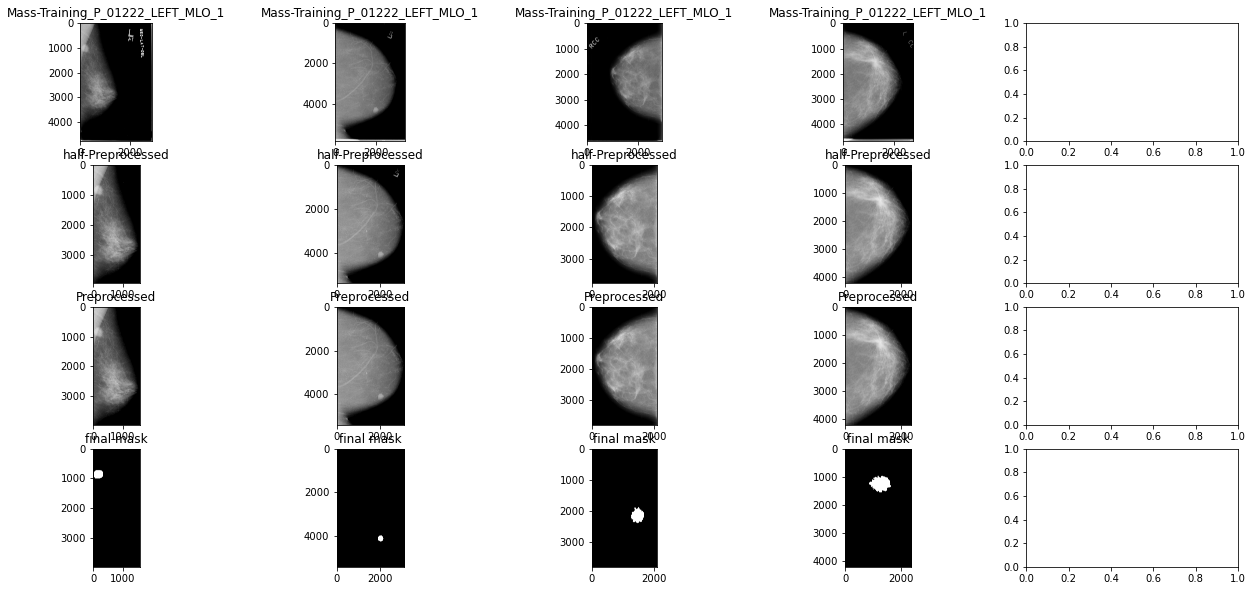

In [67]:
fig, ax = plt.subplots(nrows=4, ncols=nsamples, figsize=(22, 10))

for i in range(len(sample_initial)):
    
    # Plot original MLO scans.
    ax[0][i].imshow(sample_initial[i]["image"], cmap="gray")
    #ax[0][i].set_title(f"{sample_initial[0]["id"]}")
    ax[0][i].set_title(sample_initial[0]["id"])
    
    # Plot  medium preprocessed MLO scans.
    ax[1][i].imshow(sample_middle[i]["image"], cmap="gray")
    ax[1][i].set_title("half-Preprocessed")
    
    # Plot preprocessed MLO scans.
    ax[2][i].imshow(sample_final[i]["image"], cmap="gray")
    ax[2][i].set_title("Preprocessed")
    
    # Plot preprocessed MLO scans.
    ax[3][i].imshow(sample_mask[i]["image"], cmap="gray")
    ax[3][i].set_title("final mask")


In [22]:
len(fullmamm_paths_test)

361

In [29]:
#Preprocess test images

nsamples = 5

sample_original = fullmamm_paths_train[:nsamples]

sample_initial = []
sample_middle = []
sample_final  = []

sample_mask = []

count=0

min_id = 1201
max_id = 1232

for fullmamm_path in fullmamm_paths_test:
# for path_id in range(min_id, max_id):
# for fullmamm_path in sample_original:
    # Read full mammogram .dcm file.
    
    # fullmamm_path = fullmamm_paths_train[path_id]
    
    ds = pydicom.dcmread(fullmamm_path)
    print("Path_id = {}".format(count))

    # Get relevant metadata from .dcm file.
    patient_id = ds.PatientID
    
    fullmamm = ds.pixel_array
    
    
    mask_paths = glob.glob(fullmamm_path.replace("_FULL.dcm","") +"*MASK*")
    print(mask_paths)
    
    # =========================
    # Preprocess Full Mammogram
    # =========================
    
    if "RIGHT" in fullmamm_path.split("/")[-1]:
        orientation = "left"
    elif "LEFT" in fullmamm_path.split("/")[-1]:
        orientation = "right"
    else:
        orientation = "unknown"
        
    start_mammogram = fullmamm.copy()
    # Step 1: Initial crop.
    fullmamm = cropBorders(img=fullmamm)
    
    #Step2: larger crop
        
    try:
        # error detection using erosion. Also get cropping information for this image.
        cropping_info = crop_img_from_largest_connected(
            img=fullmamm,
            mode=orientation,
            erode_dialate=True,
            iterations=100,
            buffer_size=50,
            find_rightmost_from_ratio= 1 / 3
        )
    except Exception as error:
        print(fullmamm_path, "\n\tFailed to crop image because image is invalid.", str(error))
    else:

        top, bottom, left, right = cropping_info[0]
        
        fullmamm_pre = fullmamm[top:bottom, left:right]
        
        middle_img = fullmamm_pre.copy()
        
         # Step 3: Remove artefacts.
        binarised_img = OwnGlobalBinarise(img=fullmamm_pre, thresh=0.1, maxval=1.0)
        edited_mask = editMask(mask=binarised_img, ksize=(23, 23), operation="open")
        _, xlargest_mask = xLargestBlobs(mask=edited_mask, top_x=1)
        masked_img =applyMask(img=fullmamm_pre, mask=xlargest_mask)
    
        fullmamm_pre = masked_img

        # target_parent_dir = os.path.split(output_file_path)[0]
        
        save_filename = fullmamm_path.split("/")[-1].replace("dcm",output_format)
        save_path = os.path.join(output_test_full_path, save_filename)
        
        if not os.path.exists(output_test_full_path):
            os.makedirs(output_test_full_path)

        try:
            # saving_images.save_image_as_png(image[top:bottom, left:right], output_file_path)
            #imageio.imwrite(output_file_path, image[top:bottom, left:right])
            #imageio.imwrite(save_path, fullmamm[top:bottom, left:right])
            imageio.imwrite(save_path, fullmamm_pre)
        except Exception as error:
            print(fullmamm_path, "\n\tError while saving image.", str(error))

            
    #cropping masks
    for mask_p in mask_paths:
        # Read full mammogram .dcm file.
        ds = pydicom.dcmread(mask_p)

        # Get relevant metadata from .dcm file.
        patient_id = ds.PatientID

        mask_img = ds.pixel_array
        
        # Step 1
        mask_img = cropBorders(img=mask_img)
        
        #second crop
        mask_img = mask_img[top:bottom, left:right]
        
        save_filename = mask_p.split("/")[-1].replace("dcm",output_format)
        save_path = os.path.join(output_test_mask_path, save_filename)
        
        if not os.path.exists(output_test_mask_path):
            os.makedirs(output_test_mask_path)
            
        imageio.imwrite(save_path, mask_img)
        
        # sample_mask.append(mask_img)
        sample_mask.append({"id":patient_id, "image":mask_img})
        
    
    
    # Step 1: Initial crop.
    # cropped_img = cropBorders(img=fullmamm)
    
#     # Step 2: Remove artefacts.
#     binarised_img = OwnGlobalBinarise(img=cropped_img, thresh=0.1, maxval=1.0)
#     edited_mask = editMask(mask=binarised_img, ksize=(23, 23), operation="open")
#     _, xlargest_mask = xLargestBlobs(mask=edited_mask, top_x=1)
#     masked_img =applyMask(img=cropped_img, mask=xlargest_mask)
    
#     fullmamm_pre = masked_img
    
    
   
    # save_filename = fullmamm_path.split("/")[-1].replace("dcm",output_format)
    
    # save_path = os.path.join(output_train_full_path, save_filename)
    
    print(f"DONE FULL: {fullmamm_path}")
    
    count+=1
    if count<nsamples:
        sample_initial.append({"id":patient_id, "image":start_mammogram})
        sample_final.append({"id":patient_id, "image":fullmamm_pre})
        sample_middle.append({"id":patient_id, "image":middle_img})


print("FINISHED" )

Path_id = 0
['/datasets/mamografia/CBIS-DDSM_organized/images/original/test/Mass-Test_P_01187_LEFT_MLO_MASK_1.dcm']
DONE FULL: /datasets/mamografia/CBIS-DDSM_organized/images/original/test/Mass-Test_P_01187_LEFT_MLO_FULL.dcm
Path_id = 1
['/datasets/mamografia/CBIS-DDSM_organized/images/original/test/Mass-Test_P_00056_LEFT_MLO_MASK_1.dcm']
DONE FULL: /datasets/mamografia/CBIS-DDSM_organized/images/original/test/Mass-Test_P_00056_LEFT_MLO_FULL.dcm
Path_id = 2
['/datasets/mamografia/CBIS-DDSM_organized/images/original/test/Mass-Test_P_00498_LEFT_CC_MASK_1.dcm']
DONE FULL: /datasets/mamografia/CBIS-DDSM_organized/images/original/test/Mass-Test_P_00498_LEFT_CC_FULL.dcm
Path_id = 3
['/datasets/mamografia/CBIS-DDSM_organized/images/original/test/Mass-Test_P_00145_LEFT_CC_MASK_1.dcm']
DONE FULL: /datasets/mamografia/CBIS-DDSM_organized/images/original/test/Mass-Test_P_00145_LEFT_CC_FULL.dcm
Path_id = 4
['/datasets/mamografia/CBIS-DDSM_organized/images/original/test/Mass-Test_P_00409_RIGHT_CC_M

In [168]:
save_path

'/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/mask/Mass-Test_P_00524_LEFT_CC_FULL.png'